<a href="https://colab.research.google.com/github/shreysingla11/3D-project/blob/master/siamese_hand_gestures_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline
def W_init(shape,dtype=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,dtype=dtype)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,dtype=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,dtype=dtype)

input_shape = (105, 105, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
#convnet.add(MaxPooling2D())
convnet.add(Flatten())
convnet.add(Dropout(0.5))
convnet.add(Dense(2048,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00004)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.summary()


Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2048)         20084032    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2048)         0           sequential_1[1][0]         

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

data_path = '/content/gdrive/My Drive/Handgestures-15'
train_path = os.path.join(data_path,'train')
valid_path = os.path.join(data_path,'valid')

def loadimgs(path):
    if path == '/content/gdrive/My Drive/Handgestures-15/train':
        X = np.zeros((15,50,105,105,3))
    else:
        X = np.zeros((15,16,105,105,3))
    labels = {}
    for i,name in enumerate(os.listdir(path)):
        print(i)
        class_path = os.path.join(path,name)
        labels[name] = i
        for j,f in enumerate(os.listdir(class_path)):
            img_path = os.path.join(class_path,f)
            img = cv2.imread(img_path)
            X[i,j,:,:,:] = img
    return X,labels

In [5]:
X,c = loadimgs(train_path)
Xval,cval = loadimgs(valid_path)
data = [X,c,Xval,cval]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [0]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self,data):
        self.data = {}
        self.categories = {}
        self.info = {}
        self.data['train'] = data[0]
        self.categories['train'] = data[1]
        self.data['val'] = data[2]
        self.categories['val'] = data[3]
        
    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h ,ch = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=True)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w, 3)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 3)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h, 3)
        return pairs, targets    

    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val"):
        if N>15:
            print('exceeds number of classes')
            return
        else:
            X = self.data[s]
            n_classes,n_examples,w,h,c = X.shape
            indices = rng.randint(0,n_examples,size=(N,))
            categories = rng.randint(0,n_classes,size=(N,))
            true_category = categories[0]
            ex1,ex2 = rng.choice(n_examples,replace=False,size=(2,))
            test_image = np.asarray([X[true_category,ex1,:,:,:]]*N).reshape(N,w,h,3)
            support_set = X[categories,indices,:,:,:]
            support_set[0,:,:,:] = X[true_category,ex2]
            support_set = support_set.reshape(N,w,h,3)
            targets = np.zeros((N,))
            targets[0] = 1
            targets, test_image, support_set = shuffle(targets, test_image, support_set)
            pairs = [test_image,support_set]
            return pairs, targets
        
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            pass
            #print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size))

In [0]:
loader = Siamese_Loader(data)

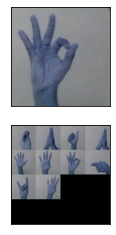

In [8]:

def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,w,h,ch = X.shape
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h,3))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h,:] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.imshow(pairs[0][0].reshape(105,105,3).astype('uint8'))
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.imshow(img.astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    plt.show()
#example of a one-shot learning task
pairs, targets = loader.make_oneshot_task(10,"train")
plot_oneshot_task(pairs)


In [9]:

#Training loop
print("!")
training_losses = []
val_accs = []
evaluate_every = 100 # interval for evaluating on one-shot tasks``
loss_every=100 # interval for printing loss (iterations)
batch_size = 64
n_iter = 10000
PATH = '/content/gdrive/My Drive'
N_way = 15 # how many classes for testing one-shot tasks>
n_val = 200 #how mahy one-shot tasks to validate on?
best = -1
weights_path = os.path.join(PATH, "weights.h5")
print("training")
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    #print(loss)
    if i % evaluate_every == 0:
        print("evaluating")
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        val_accs.append(val_acc)
        if val_acc >= best:
            #print("saving")
            siamese_net.save(weights_path)
            best=val_acc

    if i % loss_every == 0:
        training_losses.append(loss)
        print("iteration {}, training loss: {:.2f},".format(i,loss))


!
training
evaluating
Got an average of 22.0% 15 way one-shot learning accuracy
iteration 100, training loss: 2.34,
evaluating
Got an average of 13.0% 15 way one-shot learning accuracy
iteration 200, training loss: 2.12,
evaluating
Got an average of 20.5% 15 way one-shot learning accuracy
iteration 300, training loss: 2.01,
evaluating
Got an average of 14.0% 15 way one-shot learning accuracy
iteration 400, training loss: 1.96,
evaluating
Got an average of 13.5% 15 way one-shot learning accuracy
iteration 500, training loss: 1.89,
evaluating
Got an average of 23.5% 15 way one-shot learning accuracy
iteration 600, training loss: 1.84,
evaluating
Got an average of 21.5% 15 way one-shot learning accuracy
iteration 700, training loss: 1.79,
evaluating
Got an average of 18.5% 15 way one-shot learning accuracy
iteration 800, training loss: 1.74,
evaluating
Got an average of 12.5% 15 way one-shot learning accuracy
iteration 900, training loss: 1.69,
evaluating
Got an average of 19.5% 15 way on

KeyboardInterrupt: ignored

In [0]:
iters = range(100,10000,100)
plt.plot(iters,training_losses,'bo')

In [0]:
plt.plot(iters,val_accs,'b-')

In [0]:

ways = np.arange(1, 16, 1)
resume =  False
val_accs, train_accs = [], []
trials = 500
for N in ways:
    val_accs.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.show()

In [0]:
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")

plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Siamese Neural Network performance on hand gesture classification")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(15,"val")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p=siamese_net.predict(inputs)
print(p)